### Testing notebook to prototype exposure custom options

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd '/home/jovyan/dea_intertidal/dea-intertidal'

/home/jovyan/dea_intertidal/dea-intertidal


Install additional packages directly from the requirements file

In [2]:
pip install -r requirements.in --quiet

Note: you may need to restart the kernel to use updated packages.


## Load packages

In [3]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
# import re
import matplotlib.pyplot as plt

import datacube
from datacube.utils.geometry import Geometry

from intertidal.utils import (
    # load_config,
    round_date_strings,
    export_intertidal_rasters,
    intertidal_hillshade,
)
from intertidal.elevation import load_data, load_topobathy, elevation
from intertidal.extents import extents
from intertidal.exposure import exposure
from intertidal.tidal_bias_offset import bias_offset, tidal_offset_tidelines
from dea_tools.dask import create_local_dask_cluster

## Temp for tide model testing 17/07/23
from dea_tools.coastal import model_tides, pixel_tides


# !pip install sunriset

## Setup
### Set analysis parameters

In [4]:
# Intertidal Elevation variables
start_date = "2021"  # Start date for analysis
end_date = "2022"  # End date for analysis
resolution = 10  # Spatial resolution used for output files
crs = "EPSG:3577"  # Coordinate Reference System (CRS) to use for output files
ndwi_thresh = 0.1  # Threshold used to identify dry/wet transition when calculating elevation
include_s2 = True  # Include Sentinel-2 data in the analysis?
include_ls = True  # Include Landsat data in the analysis?
filter_gqa = True  # Filter to remove poorly georeferenced scenes?
tide_model = "ensemble"  # Tide model to use in analysis
tide_model_dir = "/gdata1/data/tide_models_clipped"  #  Tide models on Sandbox sharedrive
# tide_model_dir = "/var/share/tide_models"  # Directory containing tide model files
# tide_model = ["FES2014", "FES2012", "TPXO9-atlas-v5"]
# tide_model_dir = "/gdata1/data/tide_models_clipped"

# Exposure variables
# For pandas time aliases, see: https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases
modelled_freq = "30min"  # Frequency to run tidal model e.g '30T' for minutes or '1h' for hours 

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=round_date_strings(start_date, round_type="start"),
    end=round_date_strings(end_date, round_type="end"),
    freq=modelled_freq,
)

In [5]:
# # Set study area and config
# study_area = "gulfcarpentaria3"
# config_path = "configs/dea_intertidal_config_development.yaml"
# # study_area = '844'
# # config_path='configs/dea_intertidal_config.yaml'

#### *Optional: override study area selection using interactive map*

In [6]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                       layers=(basemap,),
                       center=(-26, 135),
                       zoom=4)
study_area = geom

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Intertidal workflow
#### Load data

In [7]:
# Connect to datacube
dc = datacube.Datacube(app="Intertidal_workflow")

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

satellite_ds = load_data(
    dc=dc,
    study_area=study_area,
    geom=geom,
    time_range=(start_date, end_date),
    resolution=resolution,
    crs=crs,
    include_s2=True,
    include_ls=True,
    filter_gqa=filter_gqa,
    max_cloudcover=90,
    skip_broken_datasets=True,
)

# Load data and close dask client
satellite_ds.load()
client.close()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 15,Total memory: 117.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40963,Workers: 1
Dashboard: /user/claire.phillips@ga.gov.au/proxy/8787/status,Total threads: 15
Started: Just now,Total memory: 117.21 GiB
Comm: tcp://127.0.0.1:46307,Total threads: 15
Dashboard: /user/claire.phillips@ga.gov.au/proxy/45371/status,Memory: 117.21 GiB
Nanny: tcp://127.0.0.1:34923,


/env/lib/python3.10/site-packages/datacube/drivers/driver_cache.py:54: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import iter_entry_points
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


### Load optional topobathy mask
Loads a topo-bathymetric DEM for the extents of the loaded satellite data.
This is used as a coarse mask to constrain the analysis to the coastal zone, improving run time and reducing clear false positives over deep water or elevated land.

In [8]:
# Load data from GA's Australian Bathymetry and Topography Grid 2009
topobathy_ds = load_topobathy(
    dc, satellite_ds, product="ga_multi_ausbath_0", resampling="bilinear"
)

### Intertidal elevation
To run without the topobathy DEM mask, comment out `valid_mask=...`.

In [9]:
# Model elevation for each pixel
ds, ds_aux, tide_m = elevation(
    satellite_ds,
    valid_mask=topobathy_ds.height_depth > -20,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    # config_path=config_path,
)

2024-01-12 00:49:12 INFO Modelling tide heights for each pixel


Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:18<00:00,  1.91it/s]


Returning low resolution tide array
Generating ensemble tide model from point inputs


/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2024-01-12 00:49:35 INFO Masking nodata and adding tide heights to satellite data array
2024-01-12 00:49:35 INFO Flattening satellite data array and filtering to intertidal candidate pixels
2024-01-12 00:49:35 INFO Applying valid data mask to constrain study area
2024-01-12 00:49:37 INFO Running per-pixel rolling median


Reducing analysed pixels from 194376 to 44935 (23.12%)


  0%|          | 0/105 [00:00<?, ?it/s]

2024-01-12 00:50:11 INFO Modelling intertidal elevation


Applying tidal interval interpolation to 200 intervals
Applying rolling mean smoothing with radius 20


2024-01-12 00:50:12 INFO Modelling intertidal uncertainty
2024-01-12 00:50:14 INFO Unflattening data back to its original spatial dimensions
2024-01-12 00:50:14 INFO Cleaning inaccurate upper intertidal pixels
2024-01-12 00:50:14 INFO Successfully completed intertidal elevation modelling


### Intertidal extents

In [10]:
ds['extents'] = extents(
    freq=ds_aux.ndwi_wet_freq, dem=ds.elevation, corr=ds_aux.ndwi_tide_corr)

In [11]:
# ## Plot
# labels=['0 Dry',
#        '1 Intermittent\n   wet\n   inland',
#        '2 Wet inland',
#        '3 Wet ocean',
#        '4 Intertidal lc',
#        '5 Intertidal hc',
#        ]

# fig,ax=plt.subplots(figsize=(12,8))
# cax=ax.imshow(ds['extents'], cmap='terrain_r')
# cbar=fig.colorbar(cax, ticks=[0,1,2,3,4,5])
# cbar.ax.set_yticklabels(labels)
# plt.show()


### Intertidal exposure
Calculate exposure using the script function

Nominate which filters to use for exposure calculation
#### Filter options include:
- 'unfiltered' and
- temporal_filters: 'dry', 'wet', 'summer', 'autumn', 'winter', 'spring', 'Jan', 'Feb', 'Mar', 'Apr', 
                    # 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Daylight', 'Night'
- spatial_filters: 'Spring_high', 'Spring_low', 'Neap_high', 'Neap_low', 'Hightide', 'Lowtide'

In [ ]:
## Calculate exposure without the addition of any filters
# %reload_ext autoreload

filters=['Neap_low', 'wet','unfiltered']

# ds["exposure"] = exposure(
exposure_filters, tide_cq_dict = exposure(
    dem=ds.elevation,
    time_range=all_timerange,
    modelled_freq = modelled_freq,
    tide_model=tide_model,
    tide_model_dir=tide_model_dir,
    filters=filters
    )

for x in filters:
    ds['exposure_'+str(x)]=exposure_filters[str(x)]

Calculating unfiltered exposure
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:34<00:00,  1.02it/s]


Computing tide quantiles
Returning low resolution tide array
Generating ensemble tide model from point inputs
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides using FES2014, FES2012, TPXO8-atlas-v1, TPXO9-atlas-v5, EOT20, HAMTIDE11, GOT4.10 in parallel


100%|██████████| 35/35 [00:36<00:00,  1.03s/it]


Returning low resolution tide array
Generating ensemble tide model from point inputs
Calculating statial filter: Neap_low
Calculating Neap_low


In [ ]:
ds

In [ ]:
tide_cq_dict

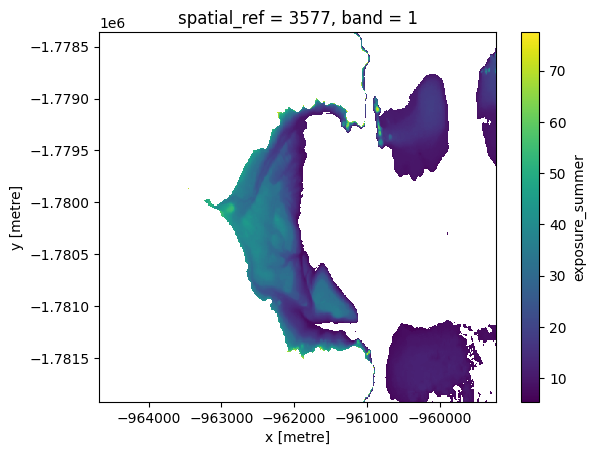

In [25]:
ds.exposure_summer.plot()